In [1]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 --quiet --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# 🔹 Load the CSV files
train_transaction = pd.read_csv("DATASET_FILE")
train_identity = pd.read_csv("DATASET_FILE")
test_transaction = pd.read_csv("DATASET_FILE")
test_identity = pd.read_csv("DATASET_FILE")

# ✅ Confirm loading
print("Train Transaction shape:", train_transaction.shape)
print("Train Identity shape:", train_identity.shape)
print("Test Transaction shape:", test_transaction.shape)
print("Test Identity shape:", test_identity.shape)

# 🔹 Merge on TransactionID
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# ✅ Check merged shapes
print("Merged Train Data shape:", train_df.shape)
print("Merged Test Data shape:", test_df.shape)

# Optional: free memory from originals
del train_transaction, train_identity, test_transaction, test_identity

Train Transaction shape: (590540, 394)
Train Identity shape: (144233, 41)
Test Transaction shape: (506691, 393)
Test Identity shape: (141907, 41)
Merged Train Data shape: (590540, 434)
Merged Test Data shape: (506691, 433)


In [3]:
# 🔹 Check for missing values (top 10 columns with most nulls)
print("Train Missing Values (%):")
print((train_df.isnull().sum() / train_df.shape[0] * 100).sort_values(ascending=False).head(10))

print("\nTest Missing Values (%):")
print((test_df.isnull().sum() / test_df.shape[0] * 100).sort_values(ascending=False).head(10))

# 🔹 Check for class balance
print("\nFraud Class Distribution:")
print(train_df['isFraud'].value_counts(normalize=True))  # Show % of 0 and 1

# 🔹 Preview data
print("\nSample of Train Data:")
print(train_df.head())

Train Missing Values (%):
id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
id_26    99.125715
id_27    99.124699
id_23    99.124699
id_22    99.124699
dist2    93.628374
dtype: float64

Test Missing Values (%):
id-24    99.064519
id-25    99.005508
id-26    99.003929
id-21    99.001561
id-08    99.001561
id-07    99.001561
id-27    99.000969
id-23    99.000969
id-22    99.000969
dist2    92.809030
dtype: float64

Fraud Class Distribution:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

Sample of Train Data:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          8

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [4]:
# Function to get columns with more than 90% null values
def get_high_null_columns(df, threshold=90):
    null_percent = df.isnull().sum() / len(df) * 100
    return list(null_percent[null_percent > threshold].index)

# Get columns to drop (intersection of train and test)
train_null_cols = set(get_high_null_columns(train_df, 90))
test_null_cols = set(get_high_null_columns(test_df, 90))
cols_to_drop = list(train_null_cols.intersection(test_null_cols))

print(f"🔹 Dropping {len(cols_to_drop)} columns with >90% nulls in both train & test")

# Drop from both datasets
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

# Confirm shapes
print("Train Shape after drop:", train_df.shape)
print("Test Shape after drop:", test_df.shape)

🔹 Dropping 1 columns with >90% nulls in both train & test
Train Shape after drop: (590540, 433)
Test Shape after drop: (506691, 432)


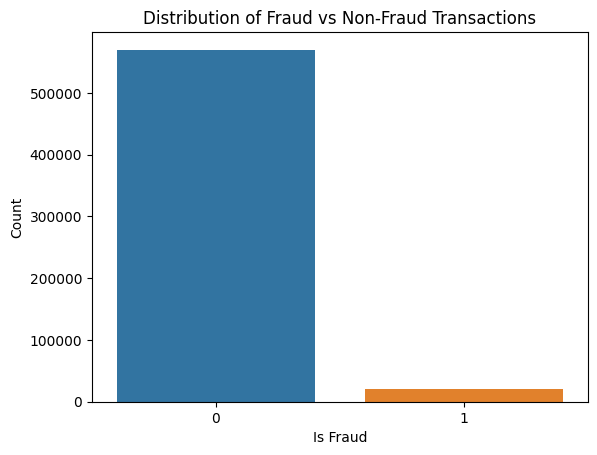

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of class distribution
sns.countplot(data=train_df, x='isFraud')
plt.title("Distribution of Fraud vs Non-Fraud Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()

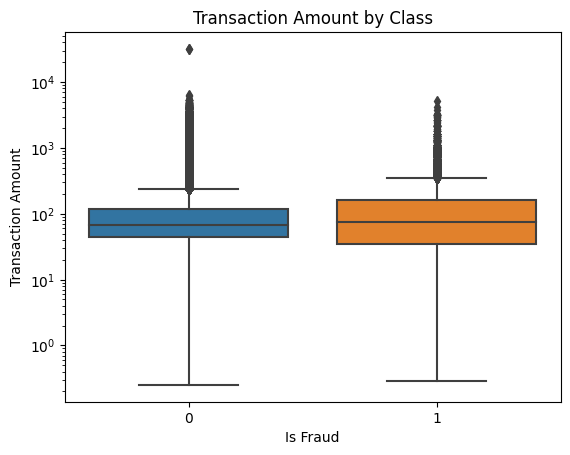

In [6]:
# Boxplot of TransactionAmt by fraud class
sns.boxplot(x='isFraud', y='TransactionAmt', data=train_df)
plt.title("Transaction Amount by Class")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount")
plt.yscale("log")  # helps to see better distribution
plt.show()

In [7]:
import pandas as pd

# Only run if TransactionDT is not already datetime
START_DATE = '2017-11-30'

# Convert TransactionDT to datetime format only if it is still numeric
if not pd.api.types.is_datetime64_any_dtype(train_df['TransactionDT']):
    train_df['TransactionDT'] = pd.to_datetime(train_df['TransactionDT'], unit='s', origin=START_DATE)

if not pd.api.types.is_datetime64_any_dtype(test_df['TransactionDT']):
    test_df['TransactionDT'] = pd.to_datetime(test_df['TransactionDT'], unit='s', origin=START_DATE)

# Extract hour and day features
train_df['TransactionHour'] = train_df['TransactionDT'].dt.hour
train_df['TransactionDay'] = train_df['TransactionDT'].dt.day

test_df['TransactionHour'] = test_df['TransactionDT'].dt.hour
test_df['TransactionDay'] = test_df['TransactionDT'].dt.day


In [8]:
train_df.drop(columns=['TransactionDT'], inplace=True)
test_df.drop(columns=['TransactionDT'], inplace=True)

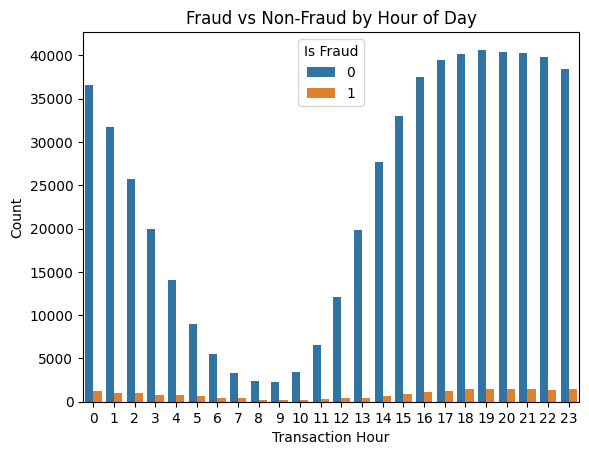

In [9]:
# Count of frauds by hour
sns.countplot(x='TransactionHour', data=train_df, hue='isFraud')
plt.title("Fraud vs Non-Fraud by Hour of Day")
plt.xlabel("Transaction Hour")
plt.ylabel("Count")
plt.legend(title='Is Fraud')
plt.show()

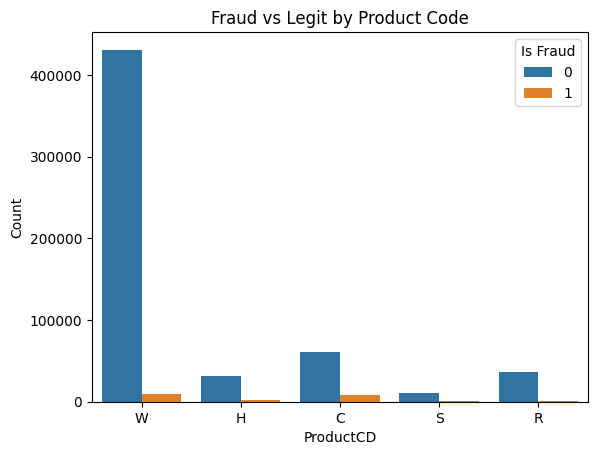

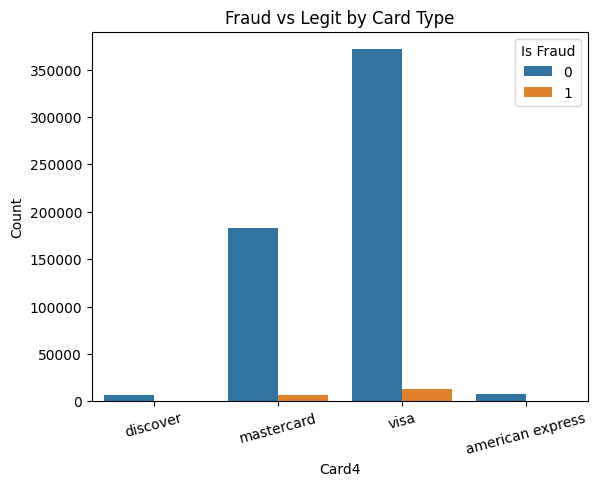

In [10]:
# ProductCD distribution
sns.countplot(data=train_df, x='ProductCD', hue='isFraud')
plt.title("Fraud vs Legit by Product Code")
plt.xlabel("ProductCD")
plt.ylabel("Count")
plt.legend(title='Is Fraud')
plt.show()

# card4 distribution (e.g., Visa/MasterCard)
sns.countplot(data=train_df, x='card4', hue='isFraud')
plt.title("Fraud vs Legit by Card Type")
plt.xlabel("Card4")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.legend(title='Is Fraud')
plt.show()

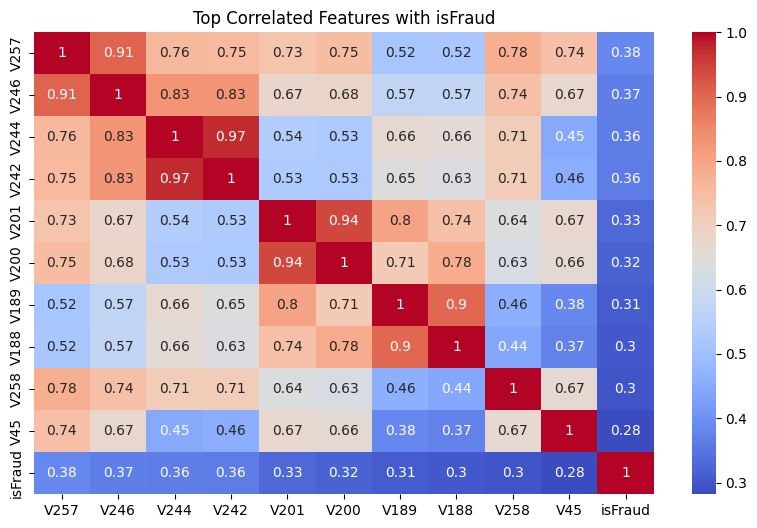

In [11]:
# Only numerical columns
numerical = train_df.select_dtypes(include=['float64', 'int64'])

# Top 10 features most correlated with isFraud
corr = numerical.corr()['isFraud'].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(10,6))
sns.heatmap(numerical[corr.index.tolist() + ['isFraud']].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with isFraud")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


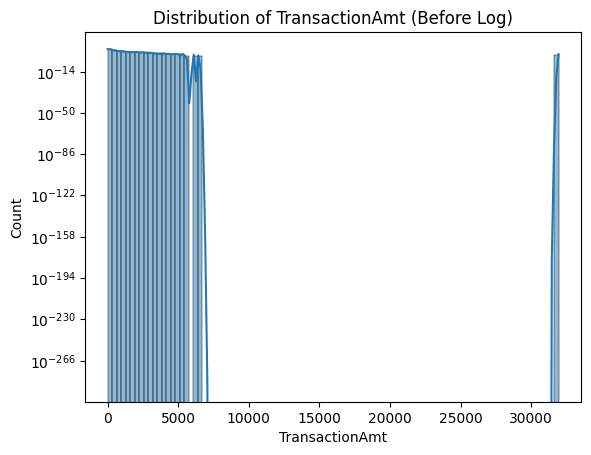

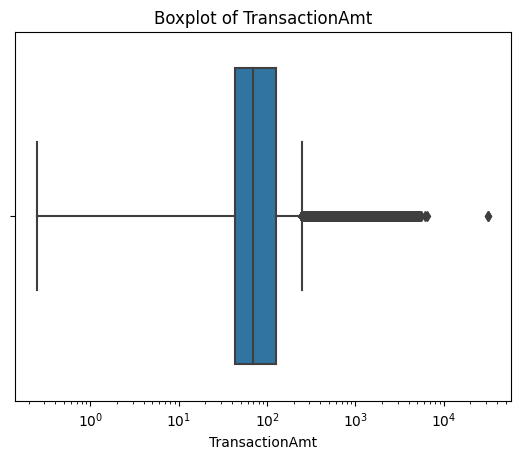

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plot
sns.histplot(train_df['TransactionAmt'], bins=100, kde=True)
plt.title("Distribution of TransactionAmt (Before Log)")
plt.xlabel("TransactionAmt")
plt.yscale('log')  # Helps view low & high density
plt.show()

# Boxplot
sns.boxplot(x=train_df['TransactionAmt'])
plt.title("Boxplot of TransactionAmt")
plt.xscale("log")
plt.show()

In [13]:
import numpy as np

train_df['TransactionAmt_log'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt_log'] = np.log1p(test_df['TransactionAmt'])

In [14]:
# Re-identify numeric and categorical columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop('isFraud', errors='ignore')
cat_cols = train_df.select_dtypes(include='object').columns

# Only use numeric columns that exist in BOTH train and test
common_num_cols = [col for col in num_cols if col in test_df.columns]

# Fill missing numeric values with train medians
for col in common_num_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

# For categorical features (handle separately)
common_cat_cols = [col for col in cat_cols if col in test_df.columns]

for col in common_cat_cols:
    train_df[col] = train_df[col].fillna('missing')
    test_df[col] = test_df[col].fillna('missing')

In [15]:
from sklearn.preprocessing import LabelEncoder

# Only encode categorical columns present in both train and test
common_cat_cols = [col for col in cat_cols if col in test_df.columns and col in train_df.columns]

# Encode safely
for col in common_cat_cols:
    try:
        le = LabelEncoder()
        combined_data = list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values)
        le.fit(combined_data)
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))
    except Exception as e:
        print(f"⚠️ Skipped column {col} due to error: {e}")

In [16]:
# 1. Drop raw TransactionAmt (we already have log version)
train_df.drop(columns=['TransactionAmt'], inplace=True, errors='ignore')
test_df.drop(columns=['TransactionAmt'], inplace=True, errors='ignore')

# 2. Drop ID/time-related columns if present
drop_cols = ['TransactionID', 'TransactionDT']
train_df.drop(columns=[col for col in drop_cols if col in train_df.columns], inplace=True)
test_df.drop(columns=[col for col in drop_cols if col in test_df.columns], inplace=True)

# 3. Split features and target
X_train = train_df.drop(columns=['isFraud'], errors='ignore')
y_train = train_df['isFraud']
X_test = test_df.copy()

# 4. Confirm final shapes
print("✅ Final Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)


✅ Final Shapes:
X_train: (590540, 432)
y_train: (590540,)
X_test : (506691, 432)


In [17]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Drop non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
X_train_numeric = X_train.drop(columns=non_numeric_cols)

# Fill missing values with median
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())

# Sample for SMOTE
X_sample = X_train_numeric.sample(frac=0.2, random_state=42)
y_sample = y_train.loc[X_sample.index]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_sample, y_sample)

print("✅ SMOTE applied successfully.")
print("🎯 Class distribution after SMOTE:\n", pd.Series(y_smote).value_counts())


✅ SMOTE applied successfully.
🎯 Class distribution after SMOTE:
 isFraud
0    113866
1    113866
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split the balanced SMOTE data
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

print("✅ Train/Test shape:", X_train_sm.shape, X_test_sm.shape)


✅ Train/Test shape: (182185, 417) (45547, 417)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


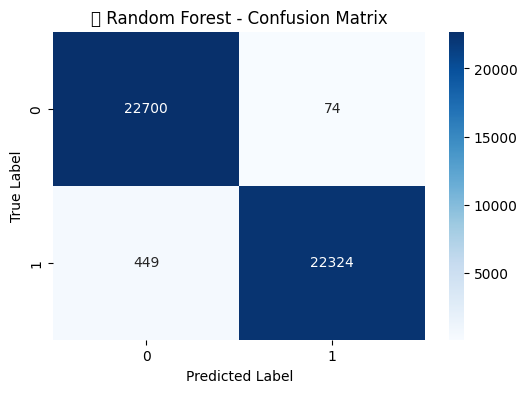

🔍 Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22774
           1       1.00      0.98      0.99     22773

    accuracy                           0.99     45547
   macro avg       0.99      0.99      0.99     45547
weighted avg       0.99      0.99      0.99     45547

✅ Accuracy      : 0.9885
✅ Precision     : 0.9967
✅ Recall        : 0.9803
✅ F1-Score      : 0.9884
✅ ROC-AUC Score : 0.9978


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sm, y_train_sm)

# ✅ Step 2: Predict and Evaluate
y_pred_rf = rf.predict(X_test_sm)
y_proba_rf = rf.predict_proba(X_test_sm)[:, 1]

# Confusion Matrix Heatmap
cm_rf = confusion_matrix(y_test_sm, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("🔍 Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report + Metrics
print("🔍 Random Forest Results:")
print(classification_report(y_test_sm, y_pred_rf))
print(f"✅ Accuracy      : {accuracy_score(y_test_sm, y_pred_rf):.4f}")
print(f"✅ Precision     : {precision_score(y_test_sm, y_pred_rf):.4f}")
print(f"✅ Recall        : {recall_score(y_test_sm, y_pred_rf):.4f}")
print(f"✅ F1-Score      : {f1_score(y_test_sm, y_pred_rf):.4f}")
print(f"✅ ROC-AUC Score : {roc_auc_score(y_test_sm, y_proba_rf):.4f}")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


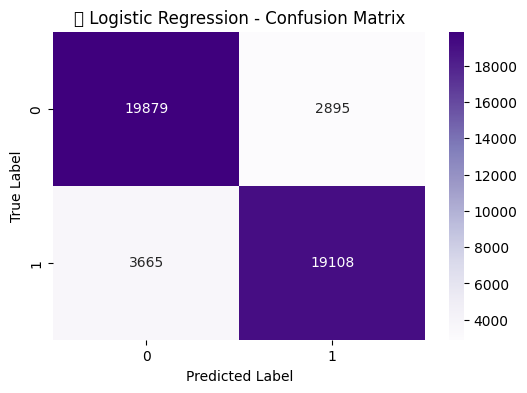

🔍 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     22774
           1       0.87      0.84      0.85     22773

    accuracy                           0.86     45547
   macro avg       0.86      0.86      0.86     45547
weighted avg       0.86      0.86      0.86     45547

✅ Accuracy      : 0.8560
✅ Precision     : 0.8684
✅ Recall        : 0.8391
✅ F1-Score      : 0.8535
✅ ROC-AUC Score : 0.9303


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

# 1️⃣ Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test_sm)

# 2️⃣ Train the Logistic Regression model
lr = LogisticRegression(max_iter=5000, random_state=42)
lr.fit(X_train_scaled, y_train_sm)

# 3️⃣ Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_test_sm, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=[0,1], yticklabels=[0,1])
plt.title("🔍 Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 5️⃣ Print classification report
print("🔍 Logistic Regression Results:")
print(classification_report(y_test_sm, y_pred_lr))

# 6️⃣ Print individual metrics
print(f"✅ Accuracy      : {accuracy_score(y_test_sm, y_pred_lr):.4f}")
print(f"✅ Precision     : {precision_score(y_test_sm, y_pred_lr):.4f}")
print(f"✅ Recall        : {recall_score(y_test_sm, y_pred_lr):.4f}")
print(f"✅ F1-Score      : {f1_score(y_test_sm, y_pred_lr):.4f}")
print(f"✅ ROC-AUC Score : {roc_auc_score(y_test_sm, y_proba_lr):.4f}")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


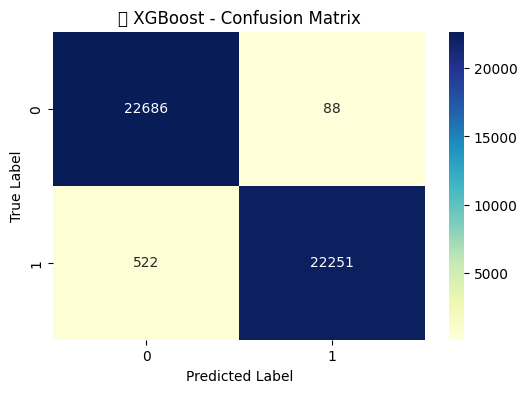

🔍 XGBoost Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22774
           1       1.00      0.98      0.99     22773

    accuracy                           0.99     45547
   macro avg       0.99      0.99      0.99     45547
weighted avg       0.99      0.99      0.99     45547

✅ Accuracy      : 0.9866
✅ Precision     : 0.9961
✅ Recall        : 0.9771
✅ F1-Score      : 0.9865
✅ ROC-AUC Score : 0.9972


In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Train
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_sm, y_train_sm)

# 2️⃣ Predict
y_pred_xgb = xgb.predict(X_test_sm)
y_proba_xgb = xgb.predict_proba(X_test_sm)[:, 1]

# 3️⃣ Confusion Matrix
cm_xgb = confusion_matrix(y_test_sm, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='YlGnBu', xticklabels=[0,1], yticklabels=[0,1])
plt.title("🔍 XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4️⃣ Metrics
print("🔍 XGBoost Results:")
print(classification_report(y_test_sm, y_pred_xgb))
print(f"✅ Accuracy      : {accuracy_score(y_test_sm, y_pred_xgb):.4f}")
print(f"✅ Precision     : {precision_score(y_test_sm, y_pred_xgb):.4f}")
print(f"✅ Recall        : {recall_score(y_test_sm, y_pred_xgb):.4f}")
print(f"✅ F1-Score      : {f1_score(y_test_sm, y_pred_xgb):.4f}")
print(f"✅ ROC-AUC Score : {roc_auc_score(y_test_sm, y_proba_xgb):.4f}")


[LightGBM] [Info] Number of positive: 91093, number of negative: 91092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.221295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98641
[LightGBM] [Info] Number of data points in the train set: 182185, number of used features: 415
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


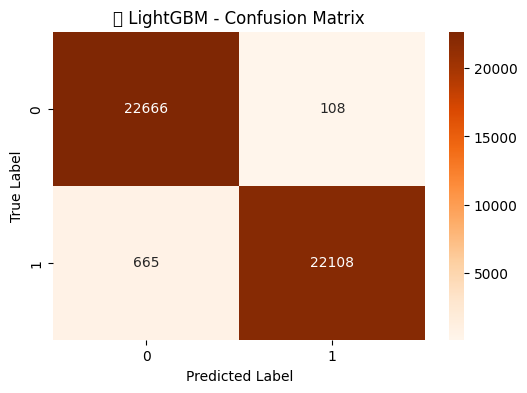

🔍 LightGBM Results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22774
           1       1.00      0.97      0.98     22773

    accuracy                           0.98     45547
   macro avg       0.98      0.98      0.98     45547
weighted avg       0.98      0.98      0.98     45547

✅ Accuracy      : 0.9830
✅ Precision     : 0.9951
✅ Recall        : 0.9708
✅ F1-Score      : 0.9828
✅ ROC-AUC Score : 0.9962


In [23]:
from lightgbm import LGBMClassifier

# 1️⃣ Train
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_sm, y_train_sm)

# 2️⃣ Predict
y_pred_lgbm = lgbm.predict(X_test_sm)
y_proba_lgbm = lgbm.predict_proba(X_test_sm)[:, 1]

# 3️⃣ Confusion Matrix
cm_lgbm = confusion_matrix(y_test_sm, y_pred_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1], yticklabels=[0,1])
plt.title("🔍 LightGBM - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4️⃣ Metrics
print("🔍 LightGBM Results:")
print(classification_report(y_test_sm, y_pred_lgbm))
print(f"✅ Accuracy      : {accuracy_score(y_test_sm, y_pred_lgbm):.4f}")
print(f"✅ Precision     : {precision_score(y_test_sm, y_pred_lgbm):.4f}")
print(f"✅ Recall        : {recall_score(y_test_sm, y_pred_lgbm):.4f}")
print(f"✅ F1-Score      : {f1_score(y_test_sm, y_pred_lgbm):.4f}")
print(f"✅ ROC-AUC Score : {roc_auc_score(y_test_sm, y_proba_lgbm):.4f}")


In [24]:
!pip install shap --quiet

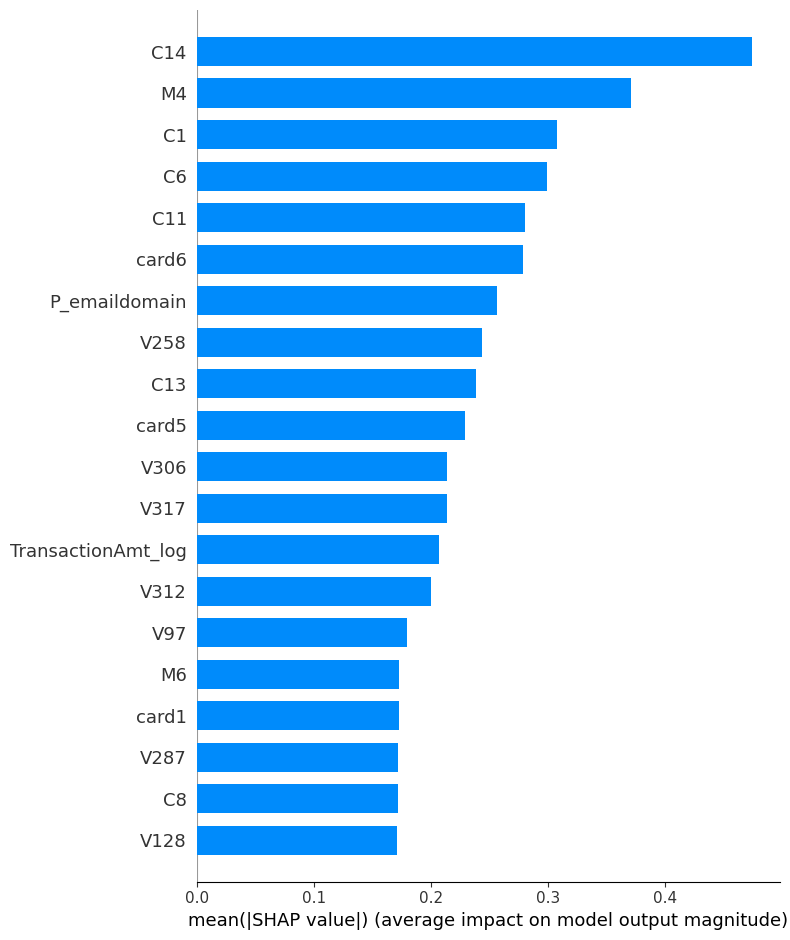

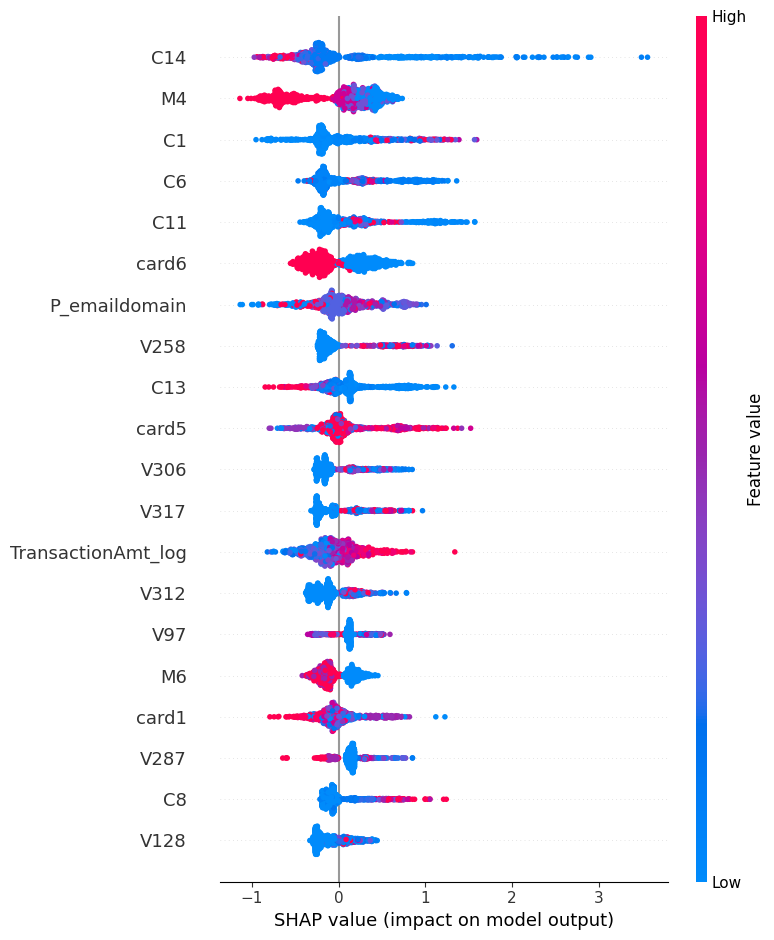

In [25]:
# 🧠 Import SHAP
import shap
import pandas as pd

# ✅ Ensure test data is in DataFrame with column names
X_test_df = pd.DataFrame(X_test_sm, columns=X_train_sm.columns)

# 🔁 Use a 1000-row sample for speed
X_sample = X_test_df.sample(n=1000, random_state=42)

# ✅ Create SHAP TreeExplainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb)

# 🔍 Compute SHAP values
shap_values_xgb = explainer_xgb.shap_values(X_sample)

# 📊 Summary plot (top features - bar)
shap.summary_plot(shap_values_xgb, X_sample, plot_type="bar")

# 📈 Beeswarm plot (detailed impact)
shap.summary_plot(shap_values_xgb, X_sample)


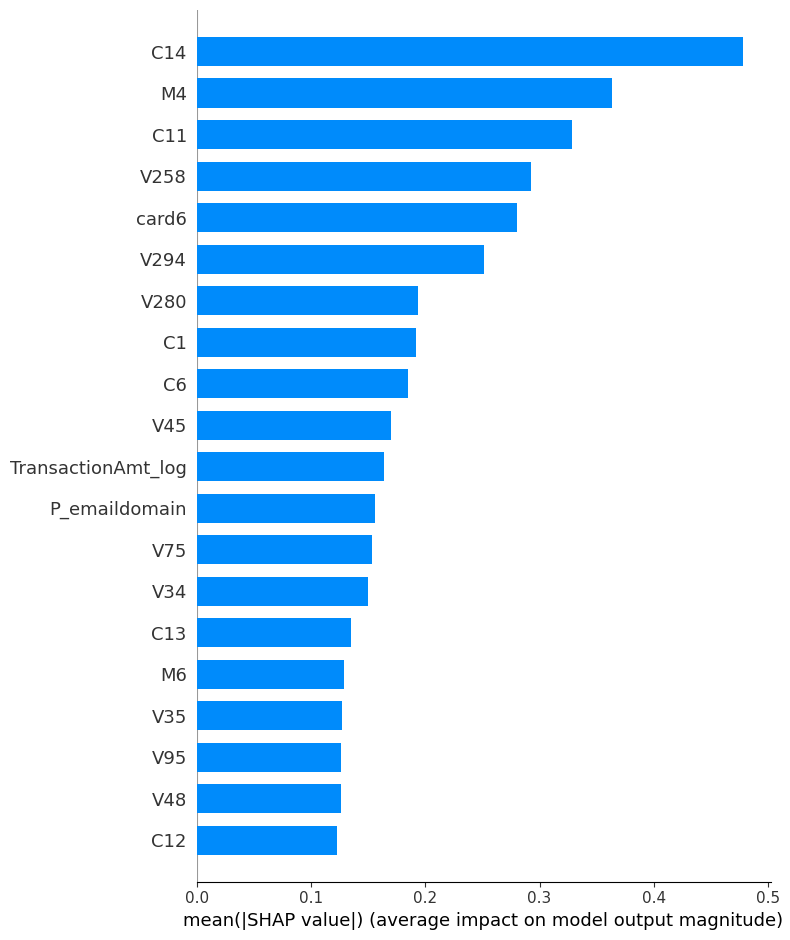

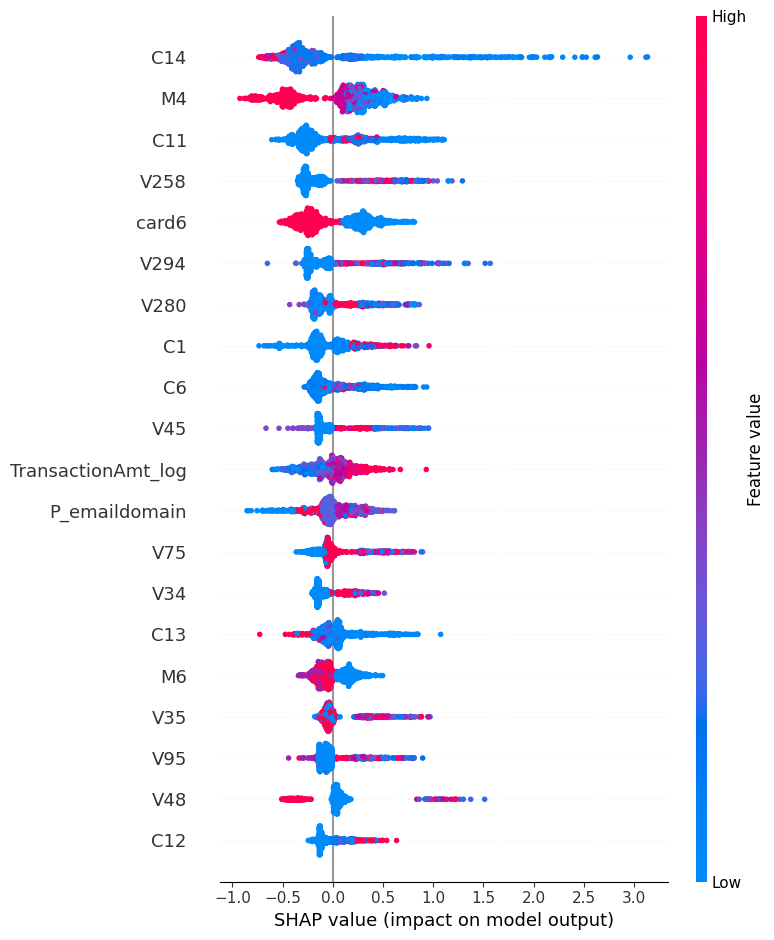

In [26]:
# Convert to DataFrame if not already
X_test_df = pd.DataFrame(X_test_sm, columns=X_train_sm.columns)
X_sample = X_test_df.sample(n=1000, random_state=42)

# SHAP Explainer for LightGBM
explainer_lgbm = shap.Explainer(lgbm)
shap_values_lgbm = explainer_lgbm(X_sample)

# For binary classification, select class 1 (fraud)
shap_values_lgbm_class1 = shap_values_lgbm[:, :, 1]

# Plot SHAP summary
shap.summary_plot(shap_values_lgbm_class1, X_sample, plot_type="bar")
shap.summary_plot(shap_values_lgbm_class1, X_sample)


  0%|          | 0/100 [00:00<?, ?it/s]

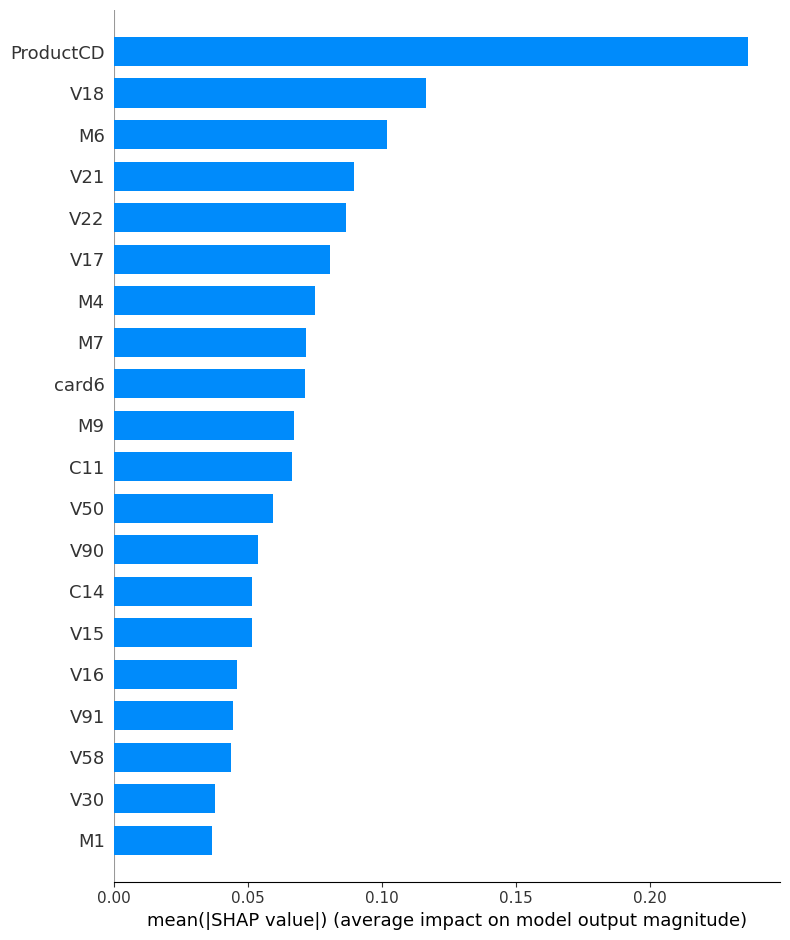

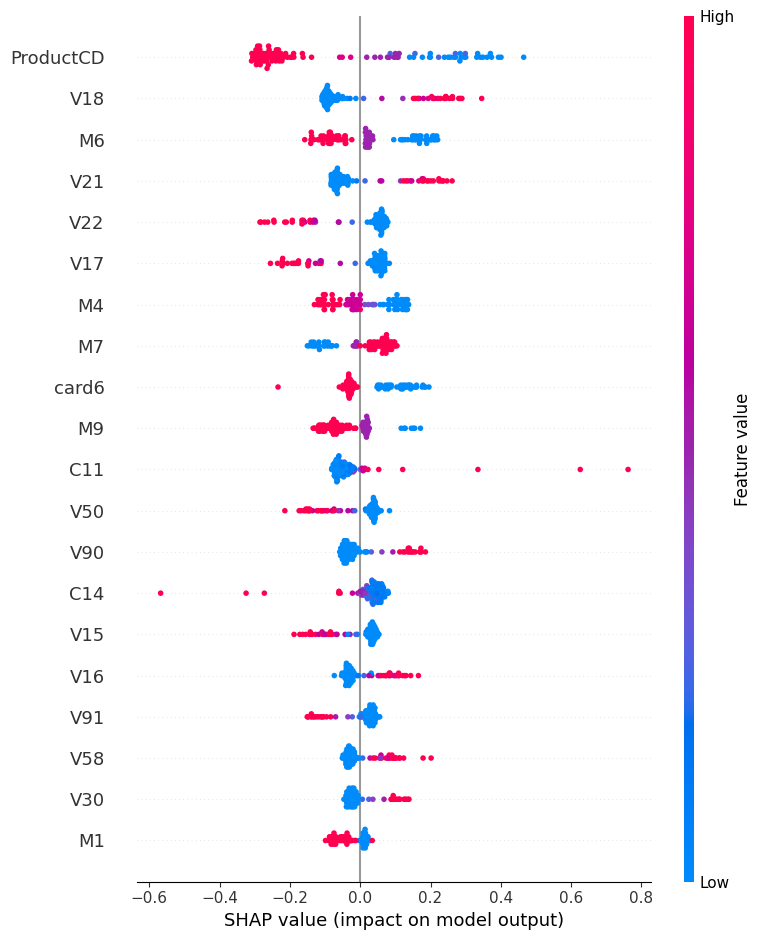

In [27]:
from sklearn.preprocessing import StandardScaler
X_test_df = pd.DataFrame(X_test_sm, columns=X_train_sm.columns)

# 🔁 Scale input data (Logistic requires it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test_df)

# Convert to DataFrame (for SHAP display)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_sm.columns)
X_sample_scaled = X_test_scaled_df.sample(n=100, random_state=42)

# KernelExplainer for Logistic Regression
explainer_lr = shap.KernelExplainer(lr.predict_proba, shap.kmeans(X_train_scaled, 10))
shap_values_lr = explainer_lr.shap_values(X_sample_scaled)

# Plot for class 1 (fraud)
shap.summary_plot(shap_values_lr[1], X_sample_scaled, plot_type="bar")
shap.summary_plot(shap_values_lr[1], X_sample_scaled)
